In [ ]:
from lusidtools.jupyter_tools import toggle_code

"""Send email notifications for order events

Attributes
----------
subscriptions
events
notifications
"""

toggle_code("Toggle Docstring")

## Introduction
This notebook was written to be used with the python SDK V2, so please ensure you have installed lusid-notifications-sdk and not lusid-notifications-sdk-preview, otherwise the authentication methods used in this notebook will not work.

### Description
This notebook demonstrates how to setup an **email notification** with an html body which includes **more information** than you initially receive from the **event body** of interest, as follows:
- Subscribe to the event of interest (i.e. OrderCreated)
- Create a webhook notification which will trigger a luminesce query
    - The luminesce query will get more information about your event of interest
    - The luminesce query will then trigger a manual event containing all of this data
- Create a subscription to the manual event
- Create an email notification triggered by the manual event subscription

### Set-up
This notebook uses a view, which accesses properties, set these up as follows:
- Create the properties (you can do this in many ways, see https://support.lusid.com/knowledgebase/article/KA-01856/en-us)
- Add the properties to the luminesce catalogue by running "AddPropertyToCatalogue.sql" in the query editor
- Create the view by running "CreateManualEventWriter-View.sql" from the query editor
- You will need to edit and re-run these files if you would like to add more properties

You will need to make changes to the "Variables Setup" section if you wish to change:
- The event triggering the email to be sent
- The data to be included in the email body
- The number of rows to be included in the html table in the email body
If you would like to access information that is not already included in the manual event you will also need to edit the "CreateManualEventWriter-View.sql" and "CreateManualEvent.sql" files to include the necessary columns, and then delete and remake the view. Information on views (including how to delete one) can be found here: https://support.lusid.com/knowledgebase/article/KA-01767/

## Setup

In [ ]:
# This is to allow us to use the same package versions every time we run this notebook
# The '!' tells the python interpreter to run this line as a shell command
! pip install -r "HelperFiles/requirements.txt"

In [ ]:
# Import generic non-LUSID packages
import os
import pandas as pd
import pprint
import json
from IPython.core.display import HTML

# Import key modules from the LUSID package
import lusid_notifications.models as models
import lusid_notifications

# Import key functions from helper packages
from lusid_notifications import (
    SyncApiClientFactory,
    EnvironmentVariablesConfigurationLoader,
    SecretsFileConfigurationLoader,
    ArgsConfigurationLoader
)
from lusidjam import RefreshingToken

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "${:,.2f}".format
display(HTML("<style>.container { width:90% !important; }</style>"))

# Authenticate user and create API client
secrets_path = os.getenv('FBN_SECRETS_PATH')
app_name = os.getenv('FBN_APP_NAME')
# lusid_domain = "fbn-xxx"
# api_url = f"https://{lusid_domain}.lusid.com/notification"
api_url = os.getenv('FBN_NOTIFICATIONS_API_URL')

config_loaders = [
	EnvironmentVariablesConfigurationLoader(),
	SecretsFileConfigurationLoader(api_secrets_file=secrets_path),
    ArgsConfigurationLoader(access_token = RefreshingToken(), api_url=api_url, app_name = app_name)
]
api_client_factory = SyncApiClientFactory(config_loaders=config_loaders)

In [ ]:
# Setup apis to be used in this notebook
subscriptions_api = api_client_factory.build(lusid_notifications.SubscriptionsApi)
notifications_api = api_client_factory.build(lusid_notifications.NotificationsApi)
event_types_api = api_client_factory.build(lusid_notifications.EventTypesApi)

### Variables Setup

In [ ]:
# Set the scope for your subscription and notification
scope = "FinbourneUniversity"

# Set the event code, subscription code and description for the subscription
event_code = "Manual"
subscription_code = "ManualEventSubscription"
subscription_filter = "body.Subject eq 'AdditionalInfoEvent'"
event_code_webhook = "OrderCreated"
subscription_code_webhook = "OrderCreatedSubscription"
subscription_desc = "An order has been created in Lusid."

# Set the ID, display name, and description for the notifications
notification_id = "OrderCreatedNotification"
notification_id_webhook = "OrderCreatedNotification_Webhook"
notification_description = "Order Creation Email Notification"
notification_description_webhook = "Order Creation Webhook Notification"

# Provide a subject, body, and addressees for your email
email_subject = "Order has been created in Lusid."
email_addresses = ["john.smith@finbourne.com","jane.doe@finbourne.com"] # Include 1+ emails in this list

# Paths to load the html email templates from
html_file_path = "HelperFiles/EmailTemplate.html"
html_file_path_2 = "HelperFiles/ExtraTableRows.html"

# Provide titles and descriptions to be included in the contents of your email
# An image of the rendered html tempate for one row of data can be found below
# You may choose the number of rows you would like to see in your email, but you must make sure
# that the number of subtitles and descriptions you provide matches the "num_rows_html_body" variable

num_rows_html_body = 4
email_title = "New Order!"
email_description = "A new order has been created."

subtitle1 = "Submitted By"
description1 = "{{Body.jsonMessage.FirstName}} {{Body.jsonMessage.LastName}}"
subtitle2 = "Timestamp"
description2 = "{{header.timestamp}}"
subtitle3 = "Order ID"
description3 = "{{Body.jsonMessage.OrderCode}}"
subtitle1_row_2 = "Order Scope"
description1_row_2 = "{{Body.jsonMessage.OrderScope}}"
subtitle2_row_2 = "Portfolio Name"
description2_row_2 = "{{Body.jsonMessage.PortfolioCode}}"
subtitle3_row_2 = "Instrument Name"
description3_row_2 = "{{Body.jsonMessage.ClientInternal}}"
subtitle1_row_3 = "Isin"
description1_row_3 = "{{Body.jsonMessage.Isin}}"
subtitle2_row_3 = "Order Quantity"
description2_row_3 = "{{Body.jsonMessage.Quantity}}"
subtitle3_row_3 = "Order Side"
description3_row_3 = "{{Body.jsonMessage.Side}}"
subtitle1_row_4 = "Order Type"
description1_row_4 = "{{Body.jsonMessage.Type}}"
subtitle2_row_4 = "Limit Price"
description2_row_4 = "{{Body.jsonMessage.LimitPrice}}"
subtitle3_row_4 = "Exposure Percentage"
description3_row_4 = "{{Body.jsonMessage.ExposurePercentage}}"

# A button labelled with "Review Now" will be included in the email (see below image)
# Set a URL that this button will direct the user to
button_url = f"https://{lusid_domain}.lusid.com/app/dashboard/order-management/orders"

# Do not edit this dictionary, this is used to generate extra rows of html
html_variables_dict_extra_rows = {
    "subtitle1": subtitle1,
    "subtitle2": subtitle2,
    "subtitle3": subtitle3,
    "description1": description1,
    "description2": description2,
    "description3": description3,
}

# Please add or remove rows to this dictionary depending on how many rows
# of data you would like to include in your email body
html_variables_dict = {
    "email_title": email_title,
    "email_description": email_description,
    "button_url": button_url,
    "subtitle1_row_2": subtitle1_row_2,
    "subtitle2_row_2": subtitle2_row_2,
    "subtitle3_row_2": subtitle3_row_2,
    "description1_row_2": description1_row_2,
    "description2_row_2": description2_row_2,
    "description3_row_2": description3_row_2,
    "subtitle1_row_3": subtitle1_row_3,
    "subtitle2_row_3": subtitle2_row_3,
    "subtitle3_row_3": subtitle3_row_3,
    "description1_row_3": description1_row_3,
    "description2_row_3": description2_row_3,
    "description3_row_3": description3_row_3,
    "subtitle1_row_4": subtitle1_row_4,
    "subtitle2_row_4": subtitle2_row_4,
    "subtitle3_row_4": subtitle3_row_4,
    "description1_row_4": description1_row_4,
    "description2_row_4": description2_row_4,
    "description3_row_4": description3_row_4,
}

html_variables_dict.update(html_variables_dict_extra_rows)

### Rendered HTML template:

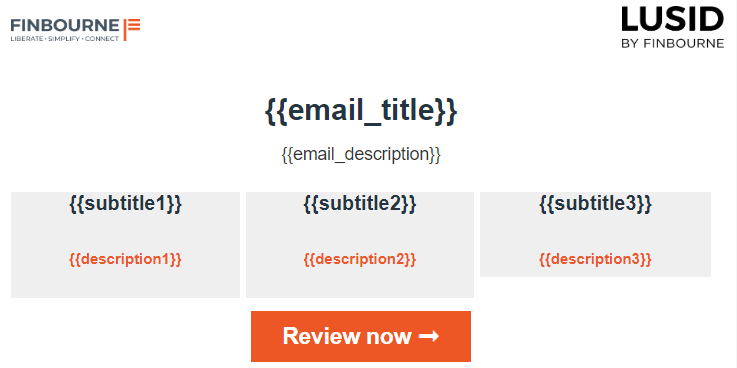

### Load html file

This cell will load the html templates from file and populate title and description placeholders in the template with the values that you provided above. This will be used to format the body of the email.

In [ ]:
def open_html_file(file_path):
    with open(file_path, 'r') as file:
        return file.read()

html_email_body = open_html_file(html_file_path)

# The below are required because using str.format() or an f string is problematic because there are so many {} used throughout the html which are not variables that we want to replace
def replace_variable_in_string_1(string,var_name,var_value):
    return string.replace("{{"+var_name+"}}",var_value)

def replace_variable_in_string_2(string,var_name,var_value):
    return string.replace("{{"+var_name+"}}","{{"+var_value+"}}")

# Insert more rows of data into the html template according to "num_rows_html_body"
if num_rows_html_body > 1:
    html_email_supplement = open_html_file(html_file_path_2)
    html_email_supplement_final = ""
    for i in range(num_rows_html_body - 1):
        html_email_supplement_n = html_email_supplement
        for name,value in html_variables_dict_extra_rows.items():
            replace_with = name + "_row_" + str(i+2)
            html_email_supplement_n = replace_variable_in_string_2(html_email_supplement_n,name,replace_with)
        html_email_supplement_final = html_email_supplement_final + "\n" + html_email_supplement_n
    html_final_email_body = replace_variable_in_string_1(html_email_body,"Extra_Rows",html_email_supplement_final)

for name,value in html_variables_dict.items():
    html_final_email_body = replace_variable_in_string_1(html_final_email_body,name,value)

## Notifications

### Subscribe to the event of interest

This cell will create a subscription to the event type specified by your 'event_code_webhook' variable.
For this sample notebook if you do not change any of the variables above this will subscribe to the "OrderCreated" event which is automatically created in Lusid whenever an order is created.

This subscription does not have a filter, so if you would like to only subscribe to a subset of the selected event_type (i.e. if you change event_type to "OrderUpdated" and only want notifications when the quantity is changed, but not for any other updates to the order, you will need to add a filter into the matching pattern.) Documentation on this can be found here: https://support.lusid.com/knowledgebase/article/KA-01819/

In [ ]:
create_subscription_request_webhook = models.CreateSubscription(
    id=models.ResourceId(
        scope=scope,
        code=subscription_code_webhook
    ),
    display_name=subscription_code_webhook,
    description=subscription_desc,
    status="Active",
    matching_pattern=models.MatchingPattern(
        event_type=event_code_webhook
    ),
)

try:
    subscription_api_response = subscriptions_api.create_subscription(create_subscription_request_webhook)
    print("The response of SubscriptionsApi->:\n")
    print(subscription_api_response)
except Exception as e:
    print(f"Exception when calling SubscriptionsApi->:\n {e}")

### Create a webhook notification which triggers a luminesce query

This cell will create a webhook notification on top of the subscription created above, which will trigger a luminesce query whenever the specified event type occurs. The luminesce query will run the code contained in "CreateManualEvent.sql"

For this sample notebook, if you do not change any of the variables above or edit the sql files, the luminesce query will trigger a manual event in Lusid, which contains more information about the order than the original "OrderCreated" event. The notification we created earlier in this notebook will then send an email based on a subscription to the manual event.

The advantage of this method over simply triggering an email directly from the original "OrderCreated" event is that it allows us to access more information about the order than is supplied in the "OrderCreated" event body, which allows us to include more detailed information in the email.

If you would like to change the information contained in the manual event you will need to edit the sql file, and subsequently edit the "Variables Setup" section to then get this information into your email notification.

In [ ]:
def create_lumi_webhook_notification(
        notifications_api,
        scope: str,
        code: str,
        sql: str,
        sub_code: str,
):

    notification_request = {
          "notificationId": code,
          "displayName": code,
          "description": notification_description_webhook,
          "notificationType": {
              "content": sql,
              "type": "Webhook",
              "httpMethod": "Put",
              "url": "/honeycomb/api/sql/json",
              "authenticationType": "Lusid",
              "contentType": "PlainText"
          }}
    
    notification_definition = models.CreateNotificationRequest.from_dict(
        notification_request
    )

    # Call LUSID API and log response detail if exception occurs.
    try:
        
        api_response = notifications_api.create_notification(
            scope=scope,
            code=sub_code,
            create_notification_request=notification_definition,
        )
        print("Notification created successfully.")
    except ValueError as ve:
        raise (ve)
    except lusid_notifications.ApiException as e:
        try:
            error_body = json.loads(e.body)
            if error_body['name'] == 'NotificationAlreadyExists':
                print('Notification already exists')
            else:
                raise (e)
        except Exception as next_e:
            raise (next_e)
        
def get_text_for_sql_query():
    f = open(
        "HelperFiles/CreateManualEvent.sql", "r")
    res = f.read()
    f.close()
    return res

sql = (get_text_for_sql_query()).replace('"',"'").replace("\n"," ")

# create luminesce webhook notification
create_lumi_webhook_notification(
    notifications_api,
    scope=scope,
    code=notification_id_webhook,
    sql=sql,
    sub_code = subscription_code_webhook
)

### Subscribe to the manual event

This cell will create a subscription to the event type specified by your 'subscription_code' variable.

For this sample notebook if you do not change any of the variables above this will subscribe to the manual event created by the webhook notification above.

In [ ]:
create_subscription_request = models.CreateSubscription(
    id=models.ResourceId(
        scope=scope,
        code=subscription_code
    ),
    display_name=subscription_code,
    description=subscription_desc,
    status="Active",
    matching_pattern=models.MatchingPattern(
        event_type=event_code,
        filter=subscription_filter
    ),
)

try:
    subscription_api_response = subscriptions_api.create_subscription(create_subscription_request)
    print("The response of SubscriptionsApi->:\n")
    print(subscription_api_response)
except Exception as e:
    print(f"Exception when calling SubscriptionsApi->:\n {e}")

### Create an email notification

This cell will create an email notification on top of the manual event subscription created above, which will send an email to all specified users when this event occurs.

In [ ]:
notification_request = {
    "notificationId": notification_id,
    "displayName": notification_id,
    "description": notification_description,
    "notificationType": {
        "type": "Email",
        "subject": email_subject,
        "plainTextBody": "Email Body",
        "htmlBody": html_final_email_body,
        "emailAddressTo": email_addresses,
        "emailAddressCc": [],
        "emailAddressBcc": []
        }}

create_notification_request = models.CreateNotificationRequest.from_dict(notification_request)

# Send the request to lusid to create the email notification
try:
    notification_api_response = notifications_api.create_notification(scope, subscription_code, create_notification_request)
    print("The response of NotificationsApi->:\n")
    print(notification_api_response)
except Exception as e:
    print(f"Exception when calling NotificationsApi->:\n {e}")

### (Optional) Delete the notifications & subscriptions

This is useful if you have made any mistakes and need to start again, or if you are running tests.

Delete the email notification.

In [ ]:
try:
    delete_notifications_response = notifications_api.delete_notification(scope,subscription_code,notification_id)
except Exception as e:
    print(f"Deletion of {notification_id} has failed: {e}")

Delete the webhook notification.

In [ ]:
try:
    delete_notifications_response = notifications_api.delete_notification(scope,subscription_code_webhook,notification_id_webhook)
except Exception as e:
    print(f"Deletion of {notification_id_webhook} has failed: {e}")

Delete the "OrderCreated" event subscription.

In [ ]:
try:
    delete_subscription_response = subscriptions_api.delete_subscription(scope,subscription_code)
except Exception as e:
    print(f"Deletion of {subscription_code} has failed: {e}")

Delete the "Manual" event subscription.

In [ ]:
try:
    delete_subscription_response = subscriptions_api.delete_subscription(scope,subscription_code_webhook)
except Exception as e:
    print(f"Deletion of {subscription_code_webhook} has failed: {e}")